In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("../input/bilingual-sentence-pairs/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
pol_eng = pol_eng[:50000,:]

In [ ]:
# Remove punctuation
pol_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in pol_eng[:,0]]
pol_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in pol_eng[:,1]]

pol_eng

array([['Go', 'Idź',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7818294 (Hanyel)'],
       ['Hi', 'Cześć',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #405641 (zipangu)'],
       ['Run', 'Uciekaj',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #6160322 (arie)'],
       ...,
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Zwykle jest wiele stron internetowych na każdy temat więc kiedy trafiam na stronę z popupami najczęściej wciskam guzik „wstecz” i idę do następnej strony znalezionej przez Googlea by trafić na coś mniej denerwującego',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #954270 (CK) & #999379 (zipangu)'],
       ['If you want to sound like a native speaker you must be willing to practic

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

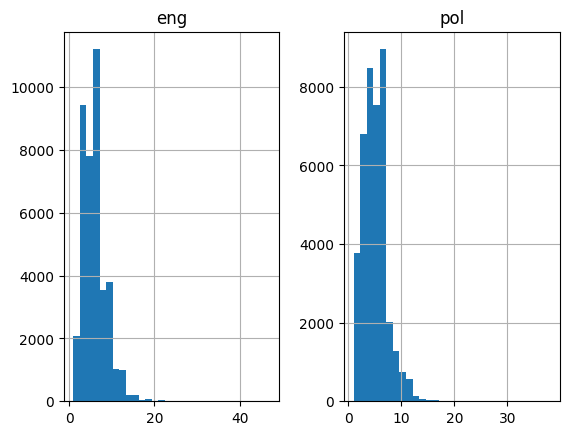

In [ ]:
# empty lists
eng_l = []
pol_l = []

# populate the lists with sentence lengths
for i in pol_eng[:,0]:
      eng_l.append(len(i.split()))

for i in pol_eng[:,1]:
      pol_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'pol':pol_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(pol_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8465


In [ ]:
# prepare Polish tokenizer
pol_tokenizer = tokenization(pol_eng[:, 1])
pol_vocab_size = len(pol_tokenizer.word_index) + 1

pol_length = 8
print('Polish Vocabulary Size: %d' % pol_vocab_size)

Polish Vocabulary Size: 21380


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(pol_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(pol_tokenizer, pol_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(pol_tokenizer, pol_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(pol_vocab_size, eng_vocab_size, pol_length, eng_length, 256)

In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 6.6776
Epoch 1: val_loss improved from inf to 5.21636, saving model to model.h1.24_jan_19
51/51 [==============================] - 132s 2s/step - loss: 6.6776 - val_loss: 5.2164
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 5.0109
Epoch 2: val_loss improved from 5.21636 to 4.88246, saving model to model.h1.24_jan_19
51/51 [==============================] - 122s 2s/step - loss: 5.0109 - val_loss: 4.8825
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 4.7954
Epoch 3: val_loss improved from 4.88246 to 4.75798, saving model to model.h1.24_jan_19
51/51 [==============================] - 129s 3s/step - loss: 4.7954 - val_loss: 4.7580
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 4.6874
Epoch 4: val_loss improved from 4.75798 to 4.66310, saving model to model.h1.24_jan_19
51/51 [==============================] - 127s 3s/step - loss: 4.6874 - val_loss: 4.6631
Epoc

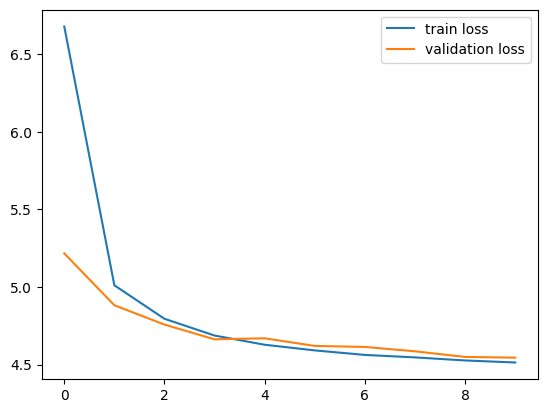

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.show()

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))), axis = -1)

253/253 [==============================] - 16s 54ms/step


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,does anyone know why tom isnt here,i you to
1,something terrible is going to happen,i you to
2,tom likes that one,i you to
3,is your watch correct,i you to
4,tom has a bruise on his right leg,i you to
5,how much money did tom give you,i you to
6,the boy i thought was honest deceived me,i you to
7,how many people are in there,i you to
8,tom mentioned the incident to mary,i you to
9,they could hardly see,i you to
